# Wave with periodic bc with the scheme from Palma: Modified with new architecture.

We solve the wave equation with Dirichlet boundary conditions (homogeneous) up to $T = 2L$ where $L$ is the space size of the integrating region. The data is reflection symmetric, $u_0(x) = u_0(L-x)$, $\partial_t u(x,t=0) = 0$. This way at the last point the solution repeats itself and we can measure the error very well.

In [1]:
import Pkg
#Pkg.add("Zygote")
#Pkg.instantiate()
#Pkg.add("StatsBase")
#Pkg.add("UnPack")
#Pkg.add("Revise")
using ComponentArrays
using Distributions
#using WGLMakie
using Lux
using LuxCUDA
using Flux #for the modified architecture
using Optim
using OptimizationOptimJL
using Random
using UnPack
using Zygote
#using CairoMakie  # Backend que funciona en notebooks
using StatsBase
using Revise
using Plots
using JLD2
using NBInclude
#import NaNMath

## Status:

Working well in both GPU and CPU without adaptivity. Using both initial data for u and its derivative.

I put some functions here.

In [8]:
includet("../../neural_tools.jl")
includet("config.jl")

In [9]:

config = config_basic
#config = config_test  # switch to config for real run

@show get_parameter_count(config)


get_parameter_count(config) = 1341


1341

**Note 1:** I attempted to put a bump function of compact support (with some if's) and could not make it run. It seems there are problems with the AD scheme to handle if's. So I put a simpler function.

**Note 2:** As it is, with adaptive it takes 12 hours (CPU) to run... And the solution is wrong...

In [10]:
# -------------------------------------------------------------------
# Second order wave equation (onda 1D): u_tt - c^2 u_xx = 0
# -------------------------------------------------------------------

function wave_equation(∂2u_∂x2, ∂2u_∂t2, config) 
    c = config[:c]
    ∂2u_∂t2 .- (c^2) .* ∂2u_∂x2
end

```
Residual at collocation points
``` 

function residual_at_points_Dirichlet(input, NN, Θ, st)
    x, t = input[1:1, :], input[2:2, :]
    _, u_xx, u_tt = calculate_derivatives_Dirichlet(x, t, NN, Θ, st)
    res = wave_equation(u_xx, u_tt, config) 
    abs_res = (abs.(u_xx) .+ abs.(u_tt))
    res = res ./ abs_res
    #res = wave_equation(u_xx, u_tt, config)
    #return vec(abs.(res |> cpu_device()))  # magnitud del residuo en CPU
    #return vec(abs.(res))
    return res
end


# -------------------------------------------------------------------
# Loss function with Dirichlet boundary conditions hard enforced.
# -------------------------------------------------------------------

function loss_function(input, NN, Θ, st)
    res = residual_at_points_Dirichlet(input[1], NN, Θ, st)
    #return log10(sum(abs2, res) / length(res))
    #return log10(sum(abs, res) / length(res))
    return sum(abs2, res) / length(res)
end

# -------------------------------------------------------------------
# Callback
# -------------------------------------------------------------------
function callback(p, l, losses)
    println("Current loss: ", l)
    push!(losses, log10(l))
    return false
end

callback (generic function with 1 method)

In [5]:
#loss_function(input_total, NN, Θ, st)

Initial data:

In [11]:
includet("wave_ini_bound_data.jl")

#plot(u0, xmin, xmax, title="Initial displacement u0(x) and velocity u1(x)", xlabel="x", ylabel="u0/u1", label="u0")
#plot!(u1, xmin, xmax, label="u1")

### Results:

1. With the p=4 polynomial data works OK and the error is of low frequency.
2. With the p=2 sin data it does not work. Start decreasing the loss function but at some point there is a problem with the optimizer and it does not improve further, on the contrary the loss stabilizes in a larger value.
It seems to be going with smaller t evolution (as if the speed were smaller)
3. We tried with rescaling the residual by the norm of the derivatives, but it does not work with SSB nor with the log10 transformation. It works very slowly with BB. 
4. With less points it seems to work (p=8), although it takes a lot of iterations and after many iterations the error is still large. I tried with Adams too. 


In [12]:
input = generate_input_x_t(config)
input0 = generate_input0_x(config)
input_bound = generate_input_boundary_x(config)
input_total = [input, input0, input_bound]

@show typeof(input_total) size(input_total)
@show get_parameter_count(config)

#input_cpu = input |> cpu_device()

# plot the inputs is needed
#scatter(input_cpu[1,:], input_cpu[2,:], markersize=1, title="Collocation points", xlabel="x", ylabel="t")

┌ Warning: No functional GPU backend found! Defaulting to CPU.
│ 
│ 1. If no GPU is available, nothing needs to be done. Set `MLDATADEVICES_SILENCE_WARN_NO_GPU=1` to silence this warning.
│ 2. If GPU is available, load the corresponding trigger package.
│     a. `CUDA.jl` and `cuDNN.jl` (or just `LuxCUDA.jl`) for  NVIDIA CUDA Support.
│     b. `AMDGPU.jl` for AMD GPU ROCM Support.
│     c. `Metal.jl` for Apple Metal GPU Support. (Experimental)
│     d. `oneAPI.jl` for Intel oneAPI GPU Support. (Experimental)
└ @ MLDataDevices.Internal /Users/reula/.julia/packages/MLDataDevices/NeohJ/src/internal.jl:112


typeof(input_total) = Vector{Array{Float64}}
size(input_total) = (3,)
get_parameter_count(config) = 1341


1341

In [15]:
# -------------------------------------------------------------------
# Entrenamiento
# -------------------------------------------------------------------
losses = []
NN, Θ, st = create_neural_network(config; to_device=:cpu)


#input_total[1] === input

MethodError: MethodError: no method matching iterate(::Nothing)
The function `iterate` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  iterate(!Matched::Parameters.Lines)
   @ Parameters ~/.julia/packages/Parameters/MK0O4/src/Parameters.jl:78
  iterate(!Matched::Parameters.Lines, !Matched::Any)
   @ Parameters ~/.julia/packages/Parameters/MK0O4/src/Parameters.jl:78
  iterate(!Matched::BitSet)
   @ Base bitset.jl:333
  ...


In [9]:
#res = residual_at_points_Dirichlet(input_total[1], NN, Θ, st)
#res_cpu = res |> cpu_device()
#@show typeof(res_cpu) size(res_cpu)
#res_cpu

In [10]:
loss_function(input_total, NN, Θ, st)

0.9995625531191483

In [11]:


#calculate_Dirichlet_f(input[1:1, :], input[2:2, :], NN, Θ, st)
#f, ∂2f_∂x2, ∂2f_∂t2 = calculate_derivatives_Dirichlet(input[1:1, :], input[2:2, :], NN, Θ, st)

In [12]:
Θ, st, losses = compute_solution_1d(config, input_total, NN, Θ, st, losses)

┌ Info: Normal training round 1 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


Current loss: 0.9995625531191483
Current loss: 0.9940232329963069
Current loss: 0.7965694282690249
Current loss: 0.7807184997648817
Current loss: 0.7785268754523301
Current loss: 0.7772297327793161
Current loss: 0.7515516547154432
Current loss: 0.7434417116452696
Current loss: 0.7434178985956464
Current loss: 0.7434162817424536
Current loss: 0.7434092640448063
Current loss: 0.7431465449069451
Current loss: 0.7431465449671589
Current loss: 0.7430555214932528
Current loss: 0.7430167279217015
Current loss: 0.7430162294231547
Current loss: 0.7425518147853343
Current loss: 0.7425484697779478
Current loss: 0.7425472637157402
Current loss: 0.7421712282035924
Current loss: 0.7421302373910825
Current loss: 0.7421185708126841
Current loss: 0.7421185618207848
Current loss: 0.7421116237497462
Current loss: 0.7420287999788163
Current loss: 0.7419658622374152
Current loss: 0.74194140150775
Current loss: 0.7419095093450231
Current loss: 0.7418658560803929
Current loss: 0.7418658263429225
Current loss

┌ Info: Normal training round 2 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7610968404593971
Current loss: 0.7610963102557371
Current loss: 0.76109630617732
Current loss: 0.7521228147937984
Current loss: 

┌ Info: Normal training round 3 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.751963800881199
Current loss: 0.7518108002879208
Current loss: 0.751711924426256
Current loss: 0.7517118654319801
Current loss: 0.7555044083846789
Current loss: 

┌ Info: Normal training round 4 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.755390657050352
Current loss: 0.7552783464828503
Current loss: 0.755261152194591
Current loss: 0.7552605196764545
Current loss: 0.7570724370791522
Current loss: 

┌ Info: Normal training round 5 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7569895974344335
Current loss: 0.7569880514215156
Current loss: 0.756988051061495
Current loss: 0.7565782894626871
Current loss: 

┌ Info: Normal training round 6 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7551392161283229
Current loss: 0.7548301444723821
Current loss: 0.7536508532489904
Current loss: 0.753457039912254
Current loss: 0.7532922231607994
Current loss: 0.7532921190535282
Current loss: 0.7532921173989271
Current loss: 0.7596826107275815
Current loss: 

┌ Info: Normal training round 7 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7582439501332551
Current loss: 0.7582435717143287
Current loss: 0.75227781597935
Current loss: 

┌ Info: Normal training round 8 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.750223192818739
Current loss: 0.7502049391929554
Current loss: 0.7502048932116142
Current loss: 0.7469428400362227
Current loss: 

┌ Info: Normal training round 9 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7456621984661926
Current loss: 0.7455829208213411
Current loss: 0.7455699479254561
Current loss: 0.7514271892619488
Current loss: 

┌ Info: Normal training round 10 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7513560522258408
Current loss: 0.751356022883396
Current loss: 0.7513560222572175
Current loss: 0.7643032009855801
Current loss: 

┌ Info: Normal training round 11 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7629190347032367
Current loss: 0.762909473937875
Current loss: 0.7629075978569763
Current loss: 0.7519256055233209
Current loss: 

┌ Info: Normal training round 12 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7495061846558246
Current loss: 0.7493392581292878
Current loss: 0.7493324789293394
Current loss: 0.7493314997249163
Current loss: 0.7626771835142695

┌ Info: Normal training round 13 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532



Current loss: 0.7626358563992643
Current loss: 0.7626358044438569
Current loss: 0.7568493886230028
Current loss: 

┌ Info: Normal training round 14 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7557958752348888
Current loss: 0.7557956529137954
Current loss: 0.7557956484466584
Current loss: 0.7473433382543051
Current loss: 

┌ Info: Normal training round 15 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7431068167592035
Current loss: 0.7428934181804726
Current loss: 0.7428885408374883
Current loss: 0.7428885053967933
Current loss: 0.7574393168207662

┌ Info: Normal training round 16 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532



Current loss: 0.7573853255776258
Current loss: 0.757382501532169
Current loss: 0.7573824797579711
Current loss: 0.7554867455762826
Current loss: 

┌ Info: Normal training round 17 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7554285357531821
Current loss: 0.7554044399904178
Current loss: 0.7554008611631975
Current loss: 0.7554008519754841
Current loss: 0.761725284712724

┌ Info: Normal training round 18 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532



Current loss: 0.761430356400714
Current loss: 0.761313341204441
Current loss: 0.761218939876956
Current loss: 0.7611829153174785
Current loss: 0.7611790696725987
Current loss: 0.7611789279637949
Current loss: 0.7572104216322536
Current loss: 

┌ Info: Normal training round 19 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7552951528976104
Current loss: 0.7548581807192529
Current loss: 0.7546098775809679
Current loss: 0.754597632389251
Current loss: 0.7545824299450846
Current loss: 0.7545823846066719
Current loss: 0.7422961266927888
Current loss: 

┌ Info: Normal training round 20 / 20  |  iters=2000
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:532


0.7422781003315663
Current loss: 0.742278069245427


((layer_1 = (weight = [-0.46456825733184814 1.509960651397705; 2.01762056350708 -0.9479922652244568; … ; 1.7667028903961182 -1.1910943984985352; -0.9101783037185669 -0.5420069098472595], bias = [0.34044942259788513, -0.12642553448677063, 0.5408093333244324, -0.638180673122406, -0.677034318447113, -0.21597149968147278, 0.5374376177787781, 0.6483078002929688, -0.6837352514266968, -0.4283216595649719, 0.18879064917564392, 0.26041415333747864, 0.14992831647396088, 0.0707063153386116, 0.5028010010719299, -0.17796581983566284, 0.5698570609092712, -0.6451494097709656, -0.13875021040439606, -0.21370306611061096]), layer_2 = (weight = [-0.20623256266117096 -0.6180484890937805 … -0.2476196438074112 -0.520729660987854; -0.03620193526148796 -0.4594805836677551 … -0.3543587327003479 0.29258593916893005; … ; 0.3984886705875397 -0.49921494722366333 … 0.0009104636847041547 -0.38884633779525757; 0.5414226055145264 0.6341953277587891 … 0.23801745474338531 -0.48196732997894287], bias = [0.209675729274749

In [13]:
# Parámetros optimizados a CPU si procede
Θ_cpu = Θ |> cpu_device()

ComponentVector{Float64}(layer_1 = (weight = [-0.46456825733184814 1.509960651397705; 2.01762056350708 -0.9479922652244568; … ; 1.7667028903961182 -1.1910943984985352; -0.9101783037185669 -0.5420069098472595], bias = [0.34044942259788513, -0.12642553448677063, 0.5408093333244324, -0.638180673122406, -0.677034318447113, -0.21597149968147278, 0.5374376177787781, 0.6483078002929688, -0.6837352514266968, -0.4283216595649719, 0.18879064917564392, 0.26041415333747864, 0.14992831647396088, 0.0707063153386116, 0.5028010010719299, -0.17796581983566284, 0.5698570609092712, -0.6451494097709656, -0.13875021040439606, -0.21370306611061096]), layer_2 = (weight = [-0.20623256266117096 -0.6180484890937805 … -0.2476196438074112 -0.520729660987854; -0.03620193526148796 -0.4594805836677551 … -0.3543587327003479 0.29258593916893005; … ; 0.3984886705875397 -0.49921494722366333 … 0.0009104636847041547 -0.38884633779525757; 0.5414226055145264 0.6341953277587891 … 0.23801745474338531 -0.48196732997894287], bi

**Save data:**

In [14]:
println("Training completed. Saving data")
#@save "wave_Dir_1.jld2" config Θ_cpu st losses
#@save "wave_dirichlet_1D_adaptive.jld2" Θ_cpu st config losses
#@save "wave_dirichlet_1D_u0_sin_u1_zero_p8_SSB.jld2" Θ_cpu st config losses
@save "wave_dirichlet_1D_u0_sin_u1_zero_p8_BB.jld2" Θ_cpu st config losses
#@save "wave_dirichlet_1D_test.jld2" Θ_cpu st config losses 

if in_nbinclude()
    exit()
end

Training completed. Saving data


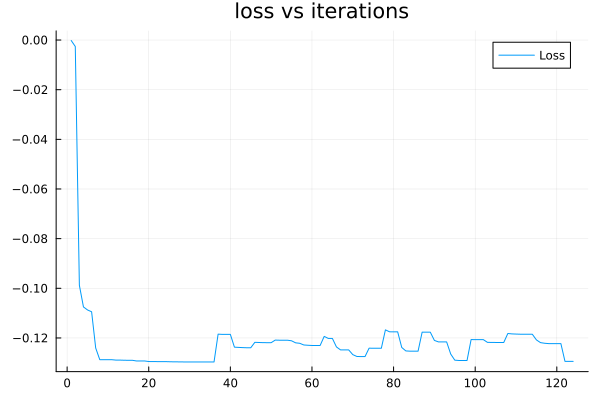

In [15]:
plot(losses, label = "Loss", title = "loss vs iterations") #, yscale = :log10)


In [16]:
losses

config[:tmax]

2.0

In [17]:
NN = create_chain(config)

Chain(
    layer_1 = Dense(2 => 20, tanh),               # 60 parameters
    layer_(2-4) = Dense(20 => 20, tanh),          # 1_260 (420 x 3) parameters
    layer_5 = Dense(20 => 1),                     # 21 parameters
)         # Total: 1_341 parameters,
          #        plus 0 states.

For the initial data with $u_1(x) = \partial_x u_0(x)$ the solution is:

$$ 
u(x,t) = 
\begin{cases}
& u_0(x+t) \;\;\;\; t \leq x \;\;\text{and} \;\;  t \leq 1 - x \\
& u_0(x+t) - u_0(x-t) \;\;\;\;\; t \geq x \;\; \text{and} \;\; t \leq 1 - x \\
& 0 \;\;\;\;\; t \leq x \;\; \text{and} \;\; t \geq 1 - x \\
& - u_0(x-t) \;\;\;\;\; t \geq x \;\; \text{and} \;\; t \geq 1 - x ;\; \text{and} \;\; t \leq 1 + x \\
\end{cases} 
$$

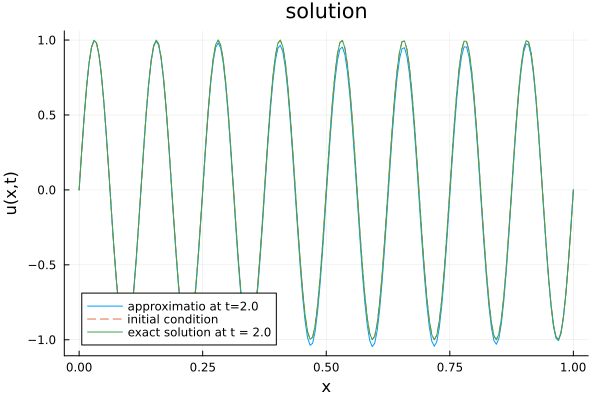

In [18]:
#@unpack xmin, xmax, A, B, p = config
t = 2.
xs = reshape(collect(range(config[:xmin], config[:xmax], length=200)), 1, :)
t_fix = reshape(fill(t, length(xs)), 1, :)
#sol_p = [calculate_Dirichlet_f(xs, t_fix, NN, Θ, st) for x in xs]
sol_p = [calculate_Dirichlet_f_wf(xs[:,i], t_fix[:,i], NN, Θ_cpu, st)[1] for i in 1:length(xs[1,:])]

plot(xs[1,:],sol_p, label = "approximatio at t=$t", title = "solution")
#lines!(xs[1,:],bump.(xs[1,:], config[:x0], config[:x1], config[:p], config[:A]), label = "initial condition")
plot!(xs[1,:],u0(xs[1,:]), label = "initial condition", linestyle = :dash)  
plot!(xlabel = "x", ylabel = "u(x,t)")   
plot!(xs[1,:], A*(sin.(2π*(xs[1,:].+t)*p/(xmax - xmin)) + sin.(2π*(xs[1,:].-t)*p/(xmax - xmin)))/2, label = "exact solution at t = $t")  # exact solution at t=2.0


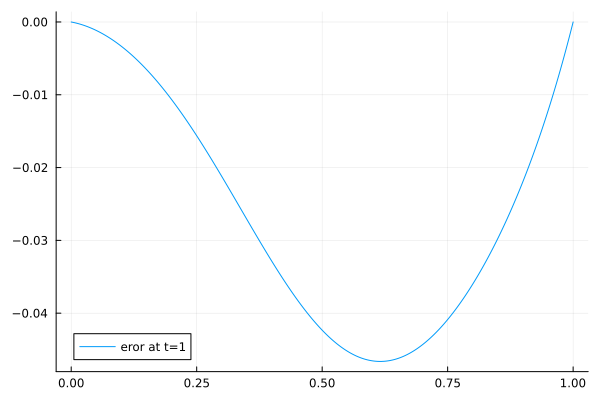

In [19]:
ax = (title = "solution")
t = 2.0
xs = reshape(collect(range(config[:xmin], config[:xmax], length=20000)), 1, :)
t_fix = reshape(fill(t, length(xs)), 1, :)
sol_p = [calculate_Dirichlet_f_wf(xs[:,i], t_fix[:,i], NN, Θ_cpu, st)[1] for i in 1:length(xs[1,:])]

plot(xs[1,:],sol_p .- u0.(xs[1,:]), label = "eror at t=1")